# CNN

In this notebook, we'll work on neural network architectures for image processing: convolutional networks.  

For pedagogical (and computational) efficiency reasons, we use a relatively small dataset consisting of 1,000 images divided into 5 classes. This corresponds to a perfectly plausible situation in practice.  

The dataset is provided in the folder `data_animals`. It consists of photos of animals from 5 categories: cat, dog, chicken, squirrel, and butterfly.

## Loading and visualizing the dataset

### Loading the dataset

We want to build a PyTorch Dataset for this complete dataset. PyTorch provides several functions to construct the Dataset; here we will use the `ImageFolder` function. As in the previous lab, we will apply a transformation to all the images in the Dataset by passing a function through the `transform` parameter (see [here](https://pytorch.org/vision/stable/transforms.html)). This time, we apply the following transformations:

- convert the images to tensors;
- scale the values to floating point numbers between 0 and 1;
- resize the images to 64 × 64 (may be changed later in the notebook to improve performance);
- normalize with a mean of 0.5 and a standard deviation of 0.5.

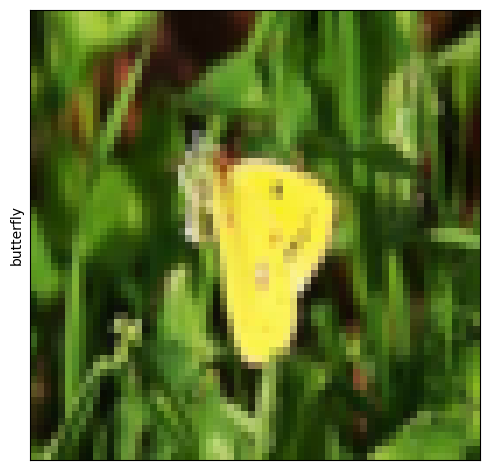

Number of images in the dataset: 1000


In [52]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import transforms, datasets, tv_tensors
from torchvision.transforms.v2 import functional as F

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.Resize((64, 64)),                  
    transforms.ToTensor(),                        
    transforms.Normalize(mean=[0.5, 0.5, 0.5],     
                         std=[0.5, 0.5, 0.5]) # 3 channels so mean and std are lists of 3 values
])

# Build the dataset using ImageFolder
dataset = datasets.ImageFolder("./data/data_animals", transform=transform)

# Retrieve one image (and its label) from the dataset:
img, label = dataset[0]


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Re-normalize the image for display purposes
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    plt.show()

# Display the selected image with its label
plot([img], row_title=[dataset.classes[label]], cmap="gray")

# Print the size of the dataset
print(f"Number of images in the dataset: {len(dataset)}")

When plotting the first image of our dataset, we indeed obtain a pixelated image. 

### Splitting the dataset 

Now we split the dataset into two parts: training and validation (ideally, a third test set would be used for final evaluation).

We need to generate two random lists of non-overlapping indices for the split. The first list will contain 80% of the indices, and the second list will contain the remaining 20%. These two lists will be used to create two DataLoaders : `train_loader` and `val_loader`, with a batch size of 32. 

In [53]:
from torch.utils.data import random_split, DataLoader

# Calculate the sizes for training and validation datasets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Randomly split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Verify the output
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 800
Validation dataset size: 200


## Building the model

We will construct a simple CNN:
- A CRP block (Convolution → ReLU → MaxPooling):
    - Convolution with 20 kernels of size 4×4×3
    - ReLU activation
    - MaxPooling (kernel 3×3, stride 2×2)
- Another CRP block:
    - Convolution with 50 kernels of size 4×4×3
    - ReLU activation
    - MaxPooling (kernel 3×3, stride 2×2)
- Flatten to convert the 3D tensor to a 1D vector
- Fully connected layer with 5 output units (for the 5 classes)

As this is a classification task, we use CrossEntropyLoss.

### Computing dimensions

In convolution or pooling, the filter moves across the image using a **stride**.

- A stride of 1 moves the filter 1 pixel at a time.
- A stride of 2 moves it 2 pixels (more efficient, but loses more information).

Here, **no padding** is applied, simplifying calculations and reducing output sizes.

The formula for calculating the output size during convolution or pooling is:

$$
O = \frac{W - K + 2P}{S} + 1
$$

Where:

- $ O $: output size
- $ W $: input size
- $ K $: kernel size
- $ P $: padding
- $ S $: stride

We will compute the output tensor dimensions for each operation in the network and determine the final vector dimension after flattening.

In [54]:
# Network hyperparameters (shared with the model cell)
channels = 3          # RGB input
conv1_channels = 20   # Number of kernels for first conv layer
conv2_channels = 50   # Number of kernels for second conv layer

# Parameters for first CRP block (Conv + Pool)
K1, S1, P1 = 4, 1, 0   # Convolution: kernel=4, stride=1, pad=0
K2, S2, P2 = 3, 2, 0   # MaxPooling: kernel=3, stride=2, pad=0

# Parameters for second CRP block (Conv + Pool)
K3, S3, P3 = 4, 1, 0   # Convolution: kernel=4, stride=1, pad=0
K4, S4, P4 = 3, 2, 0   # MaxPooling: kernel=3, stride=2, pad=0

def compute_output_size(input_size, kernel_size, stride, padding):
    output_size = (input_size - kernel_size + 2 * padding) // stride + 1
    print(f"Input size: {input_size}, Kernel size: {kernel_size}, Stride: {stride}, Padding: {padding} => Output size: {output_size}")
    return output_size

# Initial image dimensions
input_size = 64

# First CRP block calculations:
conv1_size = compute_output_size(input_size, K1, S1, P1)
pool1_size = compute_output_size(conv1_size, K2, S2, P2)
print(f"After first CRP block (Conv1 + Pool1): {pool1_size} x {pool1_size} with {conv1_channels} channels")

# Second CRP block calculations:
conv2_size = compute_output_size(pool1_size, K3, S3, P3)
pool2_size = compute_output_size(conv2_size, K4, S4, P4)
print(f"After second CRP block (Conv2 + Pool2): {pool2_size} x {pool2_size} with {conv2_channels} channels")

# Flattening
flattened_size = conv2_channels * pool2_size * pool2_size
print("Final flattened vector dimension: ", flattened_size)

Input size: 64, Kernel size: 4, Stride: 1, Padding: 0 => Output size: 61
Input size: 61, Kernel size: 3, Stride: 2, Padding: 0 => Output size: 30
After first CRP block (Conv1 + Pool1): 30 x 30 with 20 channels
Input size: 30, Kernel size: 4, Stride: 1, Padding: 0 => Output size: 27
Input size: 27, Kernel size: 3, Stride: 2, Padding: 0 => Output size: 13
After second CRP block (Conv2 + Pool2): 13 x 13 with 50 channels
Final flattened vector dimension:  8450


### Architecture implementation

Now, we can implement the architecture. We will use the `torch.nn` module to build the model. The `forward` method will define the forward pass of the network.

In [55]:
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # First CRP block: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=channels,
                               out_channels=conv1_channels,
                               kernel_size=K1, stride=S1, padding=P1)
        self.pool1 = nn.MaxPool2d(kernel_size=K2, stride=S2, padding=P2)
        # Second CRP block: Conv -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(in_channels=conv1_channels,
                               out_channels=conv2_channels,
                               kernel_size=K3, stride=S3, padding=P3)
        self.pool2 = nn.MaxPool2d(kernel_size=K4, stride=S4, padding=P4)
        # Fully connected layer: Flattened dimension to 5 classes
        self.fc = nn.Linear(flattened_size, 5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Instantiate and print the model architecture
model = MyCNN()
print(model)

# Test the model on a sample batch from the training DataLoader
images, labels = next(iter(train_loader))
output = model(images)  # This implicitly calls model.forward(images)
print("Output shape:", output.shape)
print("Predicted classes:", output.argmax(dim=1))



MyCNN(
  (conv1): Conv2d(3, 20, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=8450, out_features=5, bias=True)
)
Output shape: torch.Size([32, 5])
Predicted classes: tensor([2, 4, 4, 3, 4, 2, 2, 3, 4, 2, 3, 4, 2, 1, 4, 3, 2, 3, 4, 4, 4, 4, 4, 2,
        2, 2, 4, 3, 0, 4, 3, 2])


When printing the model we can see that each layer is defined. The output of the model is a tensor of size 5, which corresponds to the 5 classes of the dataset. Also, when printing the model's prediction for the first batch, we can see the prediction for each image in the batch.

## SGD and its variants

We can now finally train the model. We will define a training and testing loop that will iterate over the dataset and update the model's weights. We will use the SGD optimizer with a learning rate of 0.05 and a momentum of 0. We will also use the CrossEntropyLoss as the loss function. The training loop will iterate over the dataset for 5 epochs for now. 

In [57]:
import torch
import torch.optim as optim
import random
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True

# Use GPU if available
# Check if CUDA (GPU) is available and set the device accordingly
if torch.cuda.is_available():
    print("CUDA is available. Using GPU for training.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU for training.")
    device = torch.device("cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0)
criterion = torch.nn.CrossEntropyLoss()

def train_loop(dataloader, model, criterion, optimizer, epoch, return_metrics=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
    epoch_loss = running_loss / total
    accuracy = correct / total * 100
    print(f"Epoch {epoch} | Training Loss: {epoch_loss:.4f} | Training Accuracy: {accuracy:.2f}%")
    
    if return_metrics:
        return epoch_loss, accuracy
    
def test_loop(dataloader, model, criterion, epoch, return_metrics=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    epoch_loss = running_loss / total
    accuracy = correct / total * 100
    print(f"Epoch {epoch} | Validation Loss: {epoch_loss:.4f} | Validation Accuracy: {accuracy:.2f}%\n")
    
    if return_metrics:
        return epoch_loss, accuracy

# Train the model for a few epochs (≤ 5) and observe error decreasing
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train_loop(train_loader, model, criterion, optimizer, epoch)
    test_loop(valid_loader, model, criterion, epoch)


CUDA is not available. Using CPU for training.


Epoch 1 | Training Loss: 1.5902 | Training Accuracy: 25.37%
Epoch 1 | Validation Loss: 1.5190 | Validation Accuracy: 32.00%

Epoch 2 | Training Loss: 1.5111 | Training Accuracy: 32.75%
Epoch 2 | Validation Loss: 1.4310 | Validation Accuracy: 35.00%

Epoch 3 | Training Loss: 1.4437 | Training Accuracy: 38.88%
Epoch 3 | Validation Loss: 1.3863 | Validation Accuracy: 43.50%

Epoch 4 | Training Loss: 1.3930 | Training Accuracy: 43.12%
Epoch 4 | Validation Loss: 1.6899 | Validation Accuracy: 27.50%

Epoch 5 | Training Loss: 1.3319 | Training Accuracy: 46.62%
Epoch 5 | Validation Loss: 1.2648 | Validation Accuracy: 48.50%



When looking at the results of the training, we can see that the model is learning, as the loss is decreasing over time and the accuracy is increasing. However, for the validation set, the accuracy is oscillating, which isn't a good sign. 

### Evaluating different optimizers

We can try comparing different optimizers and learning rates to see if we can improve the results. 


Training with SGD (lr=0.01)...
------------------------------------------------------------
Epoch 1 | Training Loss: 1.6074 | Training Accuracy: 20.62%
Epoch 1 | Validation Loss: 1.5863 | Validation Accuracy: 27.00%

Epoch 2 | Training Loss: 1.5871 | Training Accuracy: 26.25%
Epoch 2 | Validation Loss: 1.5717 | Validation Accuracy: 31.00%

Epoch 3 | Training Loss: 1.5665 | Training Accuracy: 31.38%
Epoch 3 | Validation Loss: 1.5572 | Validation Accuracy: 26.50%

Epoch 4 | Training Loss: 1.5388 | Training Accuracy: 33.38%
Epoch 4 | Validation Loss: 1.5254 | Validation Accuracy: 36.50%

Epoch 5 | Training Loss: 1.5127 | Training Accuracy: 38.00%
Epoch 5 | Validation Loss: 1.4741 | Validation Accuracy: 40.00%


Training with SGD (lr=0.01, m=0.5)...
------------------------------------------------------------
Epoch 1 | Training Loss: 1.5973 | Training Accuracy: 21.62%
Epoch 1 | Validation Loss: 1.5694 | Validation Accuracy: 26.00%

Epoch 2 | Training Loss: 1.5510 | Training Accuracy: 29.7

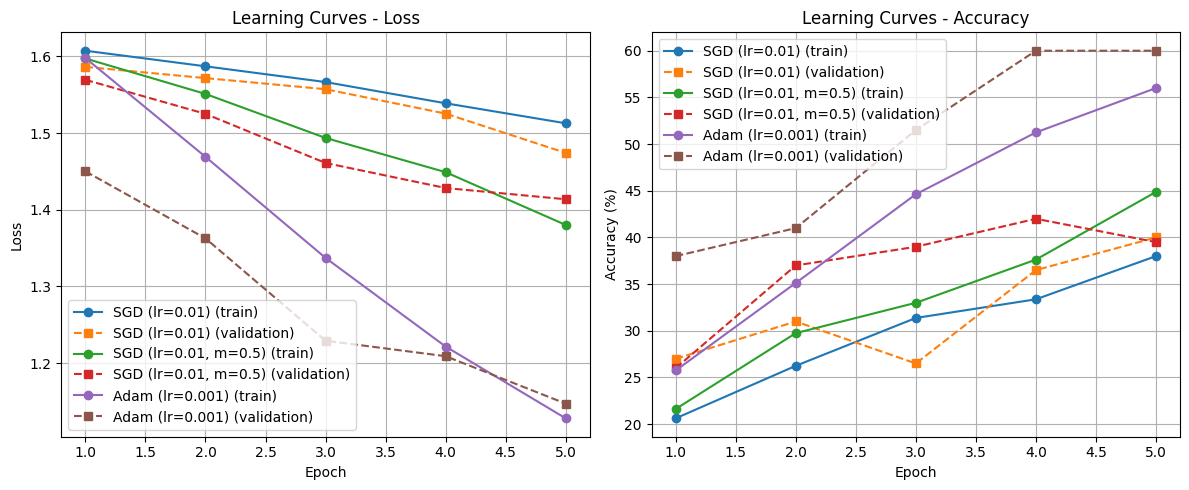


Best validation accuracy for each optimizer:
SGD (lr=0.01): 40.00% (epoch 5)
SGD (lr=0.01, m=0.5): 42.00% (epoch 4)
Adam (lr=0.001): 60.00% (epoch 4)


In [60]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to train a model and collect metrics
def learning_curves(model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    """
    Train a model and track metrics for both training and validation sets.
    
    Args:
        model: PyTorch neural network model
        optimizer: PyTorch optimizer
        criterion: Loss function
        train_loader: DataLoader for training data
        valid_loader: DataLoader for validation data
        num_epochs: Number of epochs to train
    
    Returns:
        train_losses: List of average training losses per epoch
        train_accuracies: List of training accuracies per epoch
        valid_losses: List of average validation losses per epoch
        valid_accuracies: List of validation accuracies per epoch
    """
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    # Move model to device
    model.to(device)
    
    for epoch in range(1, num_epochs + 1):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Track metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        # Calculate epoch metrics for training
        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f"Epoch {epoch} | Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.2f}%")
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Track metrics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        # Calculate epoch metrics for validation
        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_acc)
        
        print(f"Epoch {epoch} | Validation Loss: {epoch_loss:.4f} | Validation Accuracy: {epoch_acc:.2f}%\n")
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

# Test different optimizers
def compare_optimizers():
    optimizers = [
        {'name': 'SGD (lr=0.01)', 'type': 'SGD', 'lr': 0.01, 'momentum': 0},
        {'name': 'SGD (lr=0.01, m=0.5)', 'type': 'SGD', 'lr': 0.01, 'momentum': 0.5},
        {'name': 'Adam (lr=0.001)', 'type': 'Adam', 'lr': 0.001}
    ]
    
    results = {}
    criterion = torch.nn.CrossEntropyLoss()
    num_epochs = 5
    
    # Train with each optimizer configuration
    for opt in optimizers:
        print(f"\nTraining with {opt['name']}...")
        print("-" * 60)
        
        # Initialize a fresh model for fair comparison
        model = MyCNN()
        
        # Configure optimizer
        if opt['type'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=opt['lr'], momentum=opt['momentum'])
        elif opt['type'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=opt['lr'])
        
        # Train model and collect metrics
        train_losses, train_accuracies, valid_losses, valid_accuracies = learning_curves(
            model, optimizer, criterion, train_loader, valid_loader, num_epochs
        )
        
        # Store results for plotting
        results[opt['name']] = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'valid_losses': valid_losses,
            'valid_accuracies': valid_accuracies
        }
    
    # Plot learning curves
    epochs = np.arange(1, num_epochs + 1)
    
    # Plot Loss curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for name, metrics in results.items():
        plt.plot(epochs, metrics['train_losses'], 'o-', label=f'{name} (train)')
        plt.plot(epochs, metrics['valid_losses'], 's--', label=f'{name} (validation)')
    
    plt.title('Learning Curves - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy curves
    plt.subplot(1, 2, 2)
    for name, metrics in results.items():
        plt.plot(epochs, metrics['train_accuracies'], 'o-', label=f'{name} (train)')
        plt.plot(epochs, metrics['valid_accuracies'], 's--', label=f'{name} (validation)')
    
    plt.title('Learning Curves - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print best validation accuracy for each optimizer
    print("\nBest validation accuracy for each optimizer:")
    for name, metrics in results.items():
        best_acc = max(metrics['valid_accuracies'])
        best_epoch = metrics['valid_accuracies'].index(best_acc) + 1
        print(f"{name}: {best_acc:.2f}% (epoch {best_epoch})")

# Run the comparison
compare_optimizers()

The output shows that, in our case, the Adam optimizer produces the best results. The model is learning well, and the accuracy on the validation set is increasing. However, since we're only training for 5 epochs, we don't get optimal results.

### Using pre-trained models

The goal now is to use a pre-trained model. This is called **transfer learning**. It consists of using a model that has already been trained on a large dataset (like ImageNet) and adapting it to our specific task. In our case, we will use the ResNet50 model available with PyTorch.

In [61]:
from torchvision.models import resnet50

# Load the ResNet50 model
model_resnet50 = resnet50(pretrained=True)

# Print the names of all layers
print("Layers in ResNet50:")
for name, layer in model_resnet50.named_children():
    print(f"{name}: {layer}")

# Identify the last layer and its input/output sizes
last_layer_name, last_layer = list(model_resnet50.named_children())[-1]
print(f"\nLast layer: {last_layer_name}")
print(f"Last layer details: {last_layer}")
print(f"Input size: {last_layer.in_features}")
print(f"Output size: {last_layer.out_features}")

/workspaces/Artificial-Intelligence-Notebooks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspaces/Artificial-Intelligence-Notebooks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


Layers in ResNet50:
conv1: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu: ReLU(inplace=True)
maxpool: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1: Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): B

In order to use the pre-trained model, we need to modify the last layer of the model to adapt it to our task. We will replace the last layer with a new one that has 5 output units (for the 5 classes of our dataset).

In [62]:
# Replace the last layer of ResNet50 with a fully connected layer for 5 classes
model_resnet50.fc = torch.nn.Linear(in_features=last_layer.in_features, out_features=5)

# Verify the updated model
print(model_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Now, we can train the model. However we will freeze all the layers of the model except the last one. This means that we will only train the last layer of the model. This is called **fine-tuning**.

Epoch 1 | Training Loss: 1.3148 | Training Accuracy: 45.50%
Epoch 1 | Validation Loss: 1.0185 | Validation Accuracy: 68.00%

Epoch 2 | Training Loss: 0.9537 | Training Accuracy: 65.25%
Epoch 2 | Validation Loss: 0.9082 | Validation Accuracy: 67.50%

Epoch 3 | Training Loss: 0.8590 | Training Accuracy: 67.88%
Epoch 3 | Validation Loss: 0.8500 | Validation Accuracy: 70.00%

Epoch 4 | Training Loss: 0.7077 | Training Accuracy: 73.88%
Epoch 4 | Validation Loss: 0.8819 | Validation Accuracy: 66.50%

Epoch 5 | Training Loss: 0.6693 | Training Accuracy: 74.12%
Epoch 5 | Validation Loss: 0.8042 | Validation Accuracy: 70.00%



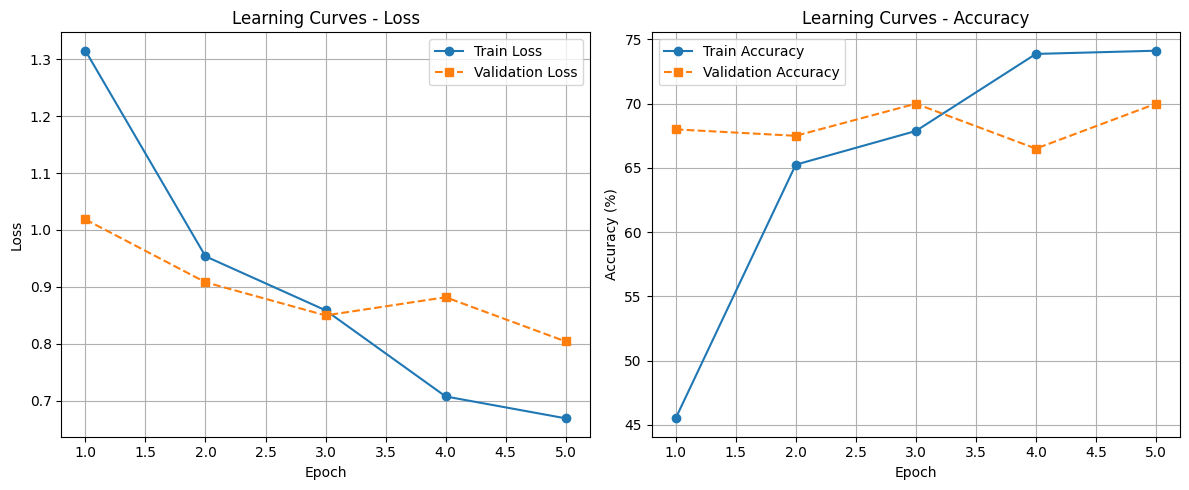

Best validation accuracy: 70.00% (epoch 3)


In [63]:
# Freeze all layers
for param in model_resnet50.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in model_resnet50.fc.parameters():
    param.requires_grad = True

# Define optimizer and loss function
optimizer = optim.Adam(model_resnet50.fc.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate the model
train_losses, train_accuracies, valid_losses, valid_accuracies = learning_curves(
    model_resnet50, optimizer, criterion, train_loader, valid_loader, num_epochs
)

# Plot learning curves
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, valid_losses, 's--', label='Validation Loss')
plt.title('Learning Curves - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 's--', label='Validation Accuracy')
plt.title('Learning Curves - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best validation accuracy
best_acc = max(valid_accuracies)
best_epoch = valid_accuracies.index(best_acc) + 1
print(f"Best validation accuracy: {best_acc:.2f}% (epoch {best_epoch})")

The model was trained for 5 epochs, and the results show an improvement compared to the previous model. However, the validation accuracy still fluctuates. Increasing the number of epochs could be a good starting point to achieve better results.